In [1]:
import pandas as pd
from pathlib import Path

from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve,RepeatedKFold

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from imblearn import over_sampling as ovs
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer,MinMaxScaler,StandardScaler

%matplotlib inline

In [2]:
sns.set_context(context="paper")
def learn_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = cv, scoring = 'r2',n_jobs=-1)
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, np.sqrt(train_scores_mean), label = 'Training error')
    plt.plot(train_sizes, np.sqrt(validation_scores_mean), label = 'Validation error')

    plt.ylabel('R2', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(-1,3)

In [3]:

#dataframe final
df_final = pd.read_csv("../data/DF_train400noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns


In [4]:
df_final.shape

(1392, 463)

In [5]:
import math
def deltaG_to_Kd(delg):
    Kd_value = math.exp((delg*1000)/(1.98*298.15))
    return Kd_value

In [6]:
X = df_final.drop('ddG_exp',axis=1).astype(float)
y = df_final['ddG_exp']

In [7]:
def log2p(target):
    return np.log(15+target)
def expm2(target):
    return np.exp(target) - 2

In [8]:
# binned split
bins = np.linspace(0, len(X), 200)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=1)                                                    

/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


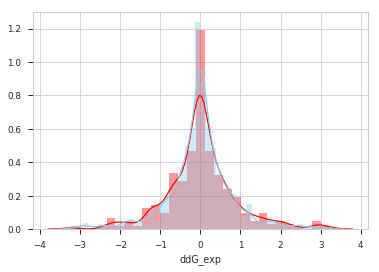

In [9]:
sns.distplot( y_test , color="red", label="ddG_exp_test")
sns.distplot( y_train , color="skyblue", label="ddG_exp_train")

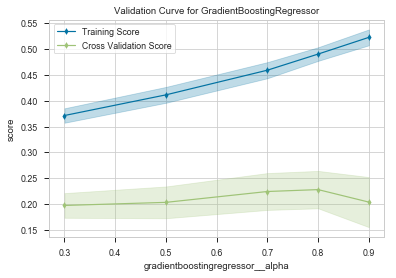

In [11]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
selector = VarianceThreshold()

#scale = MinMaxScaler()

#2)
rf_model = GradientBoostingRegressor(n_estimators=50,loss='huber')
#3) Crear pipeline


pipeline1 = make_pipeline(selector,rf_model)


cv = RepeatedKFold(n_splits=5,n_repeats=2,random_state=13)

# Extract the instances and target
viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="gradientboostingregressor__alpha",
    param_range=[0.3,0.5,0.7,0.8,0.9], cv=cv, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()


In [14]:
GradientBoostingRegressor?

In [12]:
#1)
selector = VarianceThreshold()
scale = StandardScaler()
#2)
rf_model = GradientBoostingRegressor()
#3) Crear pipeline
pipeline1 = make_pipeline(scale,selector,rf_model)

#trf = TransformedTargetRegressor(regressor=pipeline1,func=log5p,inverse_func=expm5,check_inverse=True)
# grid params
param_grid = {
    'gradientboostingregressor__max_depth': [8],
    'gradientboostingregressor__max_features': ['sqrt'],
    'gradientboostingregressor__min_samples_leaf': [25],
    'gradientboostingregressor__min_samples_split': [10],
    'gradientboostingregressor__n_estimators': [100],
    'gradientboostingregressor__subsample':[0.7,0.6,0.5],
    'gradientboostingregressor__random_state':[1212],
    'gradientboostingregressor__learning_rate':[0.05,0.06],
    'gradientboostingregressor__loss':["huber"],
    'gradientboostingregressor__alpha':[0.8],
    'variancethreshold__threshold':[0.] }

cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)

grid1.fit(X_train,y_train)

Fitting 50 folds for each of 6 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x7f9d84db97b8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gradientboostingregressor__max_depth': [8], 'gradientboostingregressor__max_features': ['sqrt'], 'gradientboostingregressor__min_samples_leaf': [25], 'gradientboostingregressor__min_samples_split': [10], 'gradientboostingregressor__n_estimators': [100], 'gradientboostingregressor__subsa..._loss': ['huber'], 'gradientboostingregressor__alpha': [0.8], 'v

In [11]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 0.717301 +/- 0.265628
CV train RMSE 0.595324 +/- 0.119099
CV test r2 0.221823 +/- 0.045638
CV train r2 0.465425 +/- 0.014996
0.2436022786995409
 {'gradientboostingregressor__alpha': 0.8, 'gradientboostingregressor__learning_rate': 0.06, 'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_depth': 8, 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_leaf': 25, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 100, 'gradientboostingregressor__random_state': 1212, 'gradientboostingregressor__subsample': 0.6, 'variancethreshold__threshold': 0.0}

RMSE for test dataset: 0.74
RMSE for train dataset: 0.59
pearson corr  0.580862
R2 test 0.28911928277892474
R2 train 0.4705454838017915


In [79]:
{'gradientboostingregressor__alpha': 0.9, 'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_leaf': 25, 'gradientboostingregressor__min_samples_split': 25, 'gradientboostingregressor__n_estimators': 35, 'gradientboostingregressor__random_state': 1212, 'gradientboostingregressor__subsample': 0.85, 'variancethreshold__threshold': 0.0}


{'gradientboostingregressor__alpha': 0.9,
 'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__loss': 'huber',
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': 'sqrt',
 'gradientboostingregressor__min_samples_leaf': 25,
 'gradientboostingregressor__min_samples_split': 25,
 'gradientboostingregressor__n_estimators': 35,
 'gradientboostingregressor__random_state': 1212,
 'gradientboostingregressor__subsample': 0.85,
 'variancethreshold__threshold': 0.0}

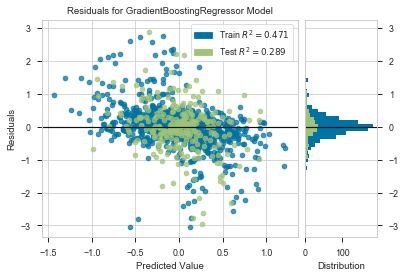

In [19]:
visualizer = ResidualsPlot(grid1.best_estimator_)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

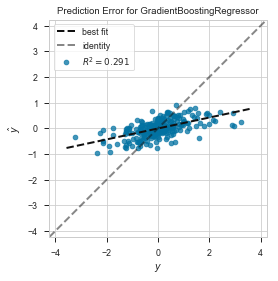

In [29]:
perror = PredictionError(grid1.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof() 

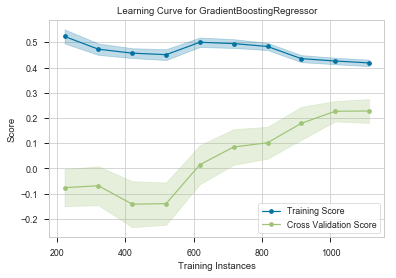

In [118]:
viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='r2',train_sizes=np.linspace(0.2, 1.0, 10))
viz.fit(X, y)
#plt.ylim(0,-4)
viz.poof()

In [119]:
final_gbt = grid1.best_estimator_.fit(X,y)

In [120]:
# save final model

joblib.dump(final_gbt, 'GBTmodel_train15skempiAB_FINAL.pkl')

['GBTmodel_train15skempiAB_FINAL.pkl']

In [29]:
feature_importance

array([  7.4170795 ,   4.66799124,  51.21485486,  12.66274975,
         4.12051018,   6.81374347,   1.09411185,   4.46429037,
         0.        ,  20.46415551,  10.00247826,  23.93446816,
         8.80638677,  22.84844866,  17.01742422,  25.43049375,
        52.69894675,   8.73415232, 100.        ,  35.77790488,
        18.58294991,  30.49395844,   9.63904266,   0.77854804,
        13.7932024 ,   7.55289192,   7.59677436,   1.70605193,
        11.02641187,   3.72510613,   7.73676921,   0.45047457,
         0.        ,   0.        ,  14.11481876,  19.18030676,
        14.99269521,   9.75597183,   8.40343678,   5.93447298,
        13.67088367,   8.30749902,  11.33394082,  10.90352102,
        10.59511913,   6.45235959,   0.        ,  18.97719001,
        10.50781728,   3.58158947,   2.04010351,  15.20456959,
        16.04357462,   5.53148272,   1.08815358,   0.        ,
         2.44879372,  38.44654458,  15.38747762,  14.93696848,
        22.65829139,  28.06067154,  21.87144049])

In [33]:
plt.xticks?

Text(0.5, 0, 'Feature importance')

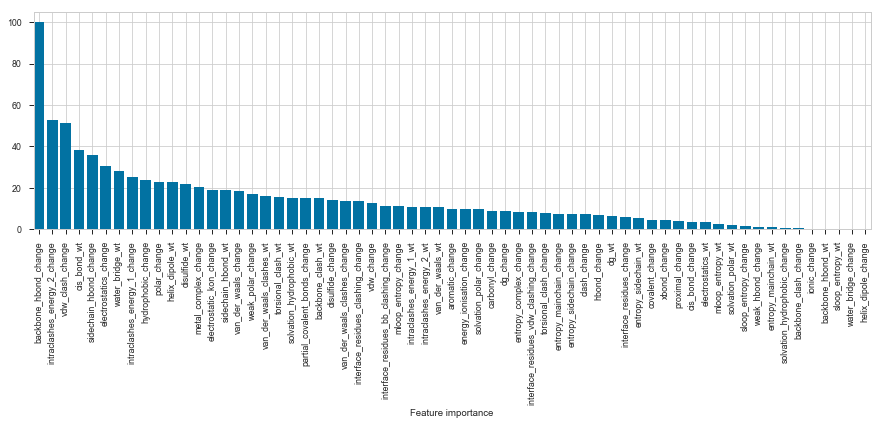

In [36]:
feature_importance = grid1.best_estimator_.named_steps['gradientboostingregressor'].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

idx_features = feature_importance.argsort()[::-1]
X_train.columns
plt.figure(figsize=(15,4))

plt.bar(np.arange(len(idx_features)), feature_importance[idx_features])
plt.xticks(range(len(df_final.columns)),df_final.columns[idx_features],rotation=90)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel(u"Feature importance")
#plt.savefig("RFmodel_300_50features",dpi=600,bbox_inches="tight")

In [24]:
importances = list(grid1.best_estimator_.named_steps['gradientboostingregressor'].feature_importances_)
feature_list = df_final.columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: backbone_hbond_change Importance: 0.1134
Variable: intraclashes_energy_2_change Importance: 0.0598
Variable: vdw_clash_change     Importance: 0.0581
Variable: cis_bond_wt          Importance: 0.0436
Variable: sidechain_hbond_change Importance: 0.0406
Variable: electrostatics_change Importance: 0.0346
Variable: water_bridge_wt      Importance: 0.0318
Variable: intraclashes_energy_1_change Importance: 0.0288
Variable: hydrophobic_change   Importance: 0.0271
Variable: polar_change         Importance: 0.0259
Variable: helix_dipole_wt      Importance: 0.0257
Variable: disulfide_wt         Importance: 0.0248
Variable: metal_complex_change Importance: 0.0232
Variable: electrostatic_kon_change Importance: 0.0218
Variable: sidechain_hbond_wt   Importance: 0.0215
Variable: van_der_waals_change Importance: 0.0211
Variable: weak_polar_change    Importance: 0.0193
Variable: van_der_waals_clashes_wt Importance: 0.0182
Variable: torsional_clash_wt   Importance: 0.0175
Variable: solvation_hy

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Salvar modelo final, entrenado con el total de lso datos

Text(4.5, -0.5, 'RMSE = 0.751')

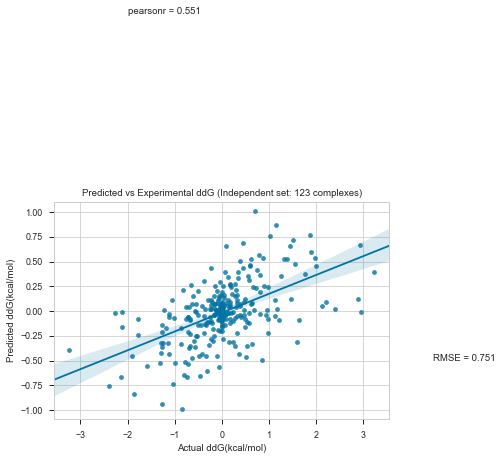

In [122]:
rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_test_pred, "Actual ddG(kcal/mol)": y_test.values})
pearsonr_test = round(df_pred.corr().iloc[0,1],3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
plt.title("Predicted vs Experimental ddG (Independent set: 123 complexes)")

plt.text(-2,3,"pearsonr = %s" %pearsonr_test)
plt.text(4.5,-0.5,"RMSE = %s" %rmse_test)

#plt.savefig("RFmodel_300_testfit.png",dpi=600)

Text(0.5, 1.0, 'Predicted vs Experimental ddG (Train set: 492 complexes)')

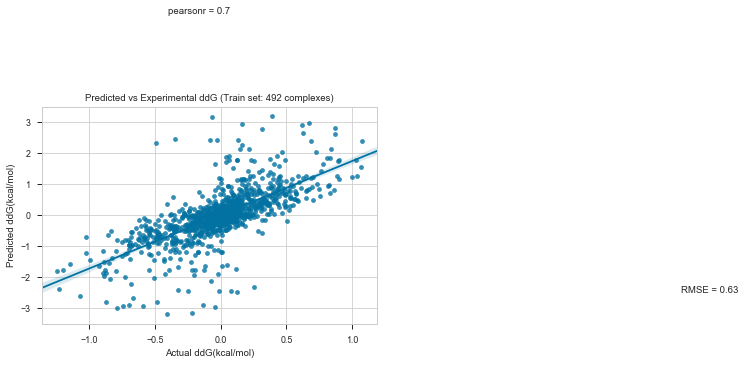

In [123]:
df_train_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_train, "Actual ddG(kcal/mol)": y_train_pred})
pearsonr_train = round(df_train_pred.corr().iloc[0,1],3)
rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_train_pred)

plt.text(-0.4,6.5,"pearsonr = %s" %pearsonr_train)
plt.text(3.5,-2.5,"RMSE = %s" %rmse_train)
plt.title("Predicted vs Experimental ddG (Train set: 492 complexes)")
#plt.savefig("RFmodel_300_trainfit.png",dpi=600)


In [86]:
rf_model = grid1.best_estimator_.named_steps["randomforestregressor"]
importances = list(rf_model.feature_importances_)
feature_list = df_final.columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: dg_change            Importance: 0.0632
Variable: van_der_waals_change Importance: 0.0571
Variable: solvation_polar_change Importance: 0.056
Variable: helix_dipole_wt      Importance: 0.0362
Variable: torsional_clash_change Importance: 0.0325
Variable: sidechain_hbond_change Importance: 0.031
Variable: backbone_clash_change Importance: 0.031
Variable: solvation_hydrophobic_change Importance: 0.0304
Variable: backbone_hbond_change Importance: 0.03
Variable: if_phil              Importance: 0.0288
Variable: if_total             Importance: 0.0263
Variable: van_der_waals_clashes_change Importance: 0.0257
Variable: intraclashes_energy_1_change Importance: 0.0256
Variable: van_der_waals_clashes_wt Importance: 0.0254
Variable: dg_wt                Importance: 0.0252
Variable: sasa_phil_mut        Importance: 0.0249
Variable: intraclashes_energy_1_wt Importance: 0.0242
Variable: torsional_clash_wt   Importance: 0.0226
Variable: hbond                Importance: 0.019
Variable: energy

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 0, 'Feature importance')

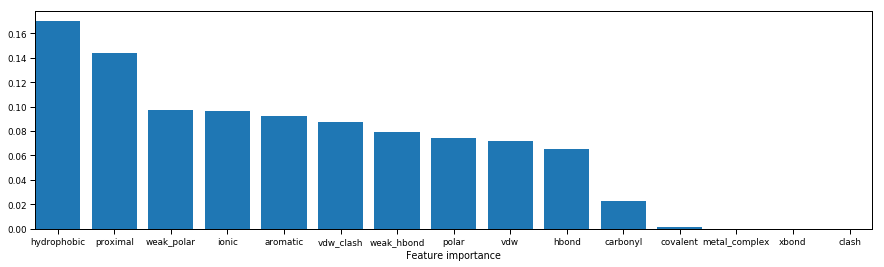

In [23]:
idx_features = model.feature_importances_.argsort()[::-1]
plt.figure(figsize=(15,4))

plt.bar(np.arange(X_train.shape[1]), model.feature_importances_[idx_features])
plt.xticks(range(len(feature_list)),feature_list[idx_features])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel(u"Feature importance")
#plt.savefig("RFmodel_300_50features",dpi=600,bbox_inches="tight")

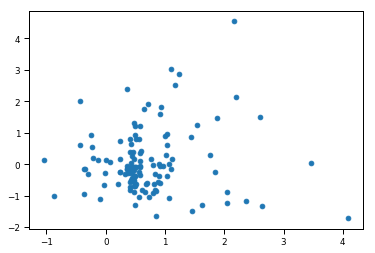

In [15]:
residual = y_test.values - y_pred_test
plt.scatter(x=y_pred_test.T, y=residual.T)

In [16]:
from sklearn.model_selection import learning_curve
def learning_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = cv, scoring = 'neg_mean_squared_error',n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, np.sqrt(train_scores_mean), label = 'Training error')
    plt.plot(train_sizes, np.sqrt(validation_scores_mean), label = 'Validation error')

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,3)

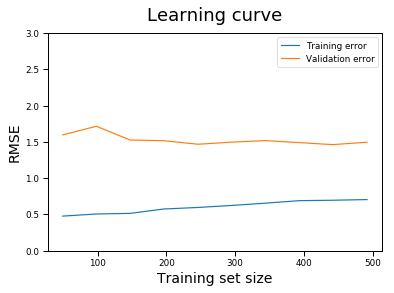

In [17]:
learning_curves(model,X,y,5)
#plt.savefig("RFmodel_300_learnincurve.png",dpi=600,bbox_inches="tight")

# Manuall CV with smote

In [127]:
# forma 1
df_final['class'] = np.where((df_final['ddG_exp'] < -0.4) | (df_final['ddG_exp'] > 2.4),0,1)
# forma 2 
#df_final['class'] = np.where((df_final['ddG_exp'] < 0),1,0)

In [128]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 481
Before OverSampling, counts of label '0': 134


In [129]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,train_size=0.70,random_state=1212)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [131]:
RandomForestRegressor?

In [ ]:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 2, 'randomforestregressor__max_features': 37, 'randomforestregressor__max_leaf_nodes': 12, 'randomforestregressor__min_samples_leaf': 10, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 1212}

In [132]:
cv_splits = 10

cv_test_mse = np.zeros(cv_splits)
cv_test_r2 = np.zeros(cv_splits)
cv_train_mse = np.zeros(cv_splits)
cv_train_r2 = np.zeros(cv_splits)

kf = KFold(n_splits=cv_splits,random_state=1212)
#kf = StratifiedKFold(n_splits=cv_splits,random_state=12)
for i,(train_index, validation_index) in enumerate(kf.split(X_train,y_train)):
    
    X_train_cv, X_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train.values[train_index], y_train.values[validation_index]
    
    # Oversampling
    smote = ovs.SMOTE(random_state=1212,m_neighbors=25)
    #smote = ovs.BorderlineSMOTE(random_state=12,m_neighbors=40,kind='borderline-1')
    #adasyn = ovs.ADASYN(random_state=12,n_neighbors=40)
    #X_train_ovs , y_train_ovs = adasyn.fit_sample(X_train_cv,y_train_cv)
    X_train_ovs , y_train_ovs = smote.fit_sample(X_train_cv,y_train_cv)
    
    # Back to normal dataset
    X_train_normal = X_train_ovs[:,:-1]
    y_train_normal = X_train_ovs[:,-1]
    
    X_validation_normal = X_validation_cv[:,:-1]
    y_validation_normal = X_validation_cv[:,-1]
    
    
    # Model
    model = RandomForestRegressor(n_estimators=50,max_depth=2,max_features=30,max_leaf_nodes=10,
                                  min_samples_leaf=2,min_samples_split=10,random_state=1212)
    model.fit(X_train_normal,y_train_normal)
    
    # Test
    y_test_pred = model.predict(X_validation_normal)
    y_train_pred = model.predict(X_train_normal)
    
    # Scoring
    
    test_mse = mean_squared_error(y_validation_normal,y_test_pred)
    test_r2 = r2_score(y_validation_normal,y_test_pred)
    cv_test_mse[i] = test_mse
    cv_test_r2[i] = test_r2
    
    train_mse = mean_squared_error(y_train_normal,y_train_pred)
    train_r2 = r2_score(y_train_normal,y_train_pred)
    cv_train_mse[i] = train_mse
    cv_train_r2[i] = train_r2
    
print("Test scores")
print("RMSE",np.sqrt(cv_test_mse.mean()))
print("r2",cv_test_r2.mean())
print("")
print("Train scores")
print("RMSE",np.sqrt(cv_train_mse.mean()))
print("r2",cv_train_r2.mean())


Test scores
RMSE 1.1960745680680778
r2 0.30202439829554173

Train scores
RMSE 1.1520470964345404
r2 0.5917545697264857
